# Setting the Scene

Imagine you are working for a social media company. The company is concerned with the growing amount of fake news circulatng on it's platform. They have assigned you to investigate how fake news can be recognized and create a method of identifying it. Let's work through this problem together, first by exploring and cleaning the data and then working to classify fake vs factual news stories. We'll also create some plots of our outputs and discuss how we would communicate our findings to stakeholders.

# Import packages

In [1]:
!pip install vaderSentiment

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [3]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# set plot options
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = "#00bfbf"

# Load Data

In [5]:
data = pd.read_csv("fake_news_data.csv")

In [6]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 0, 'Classification')

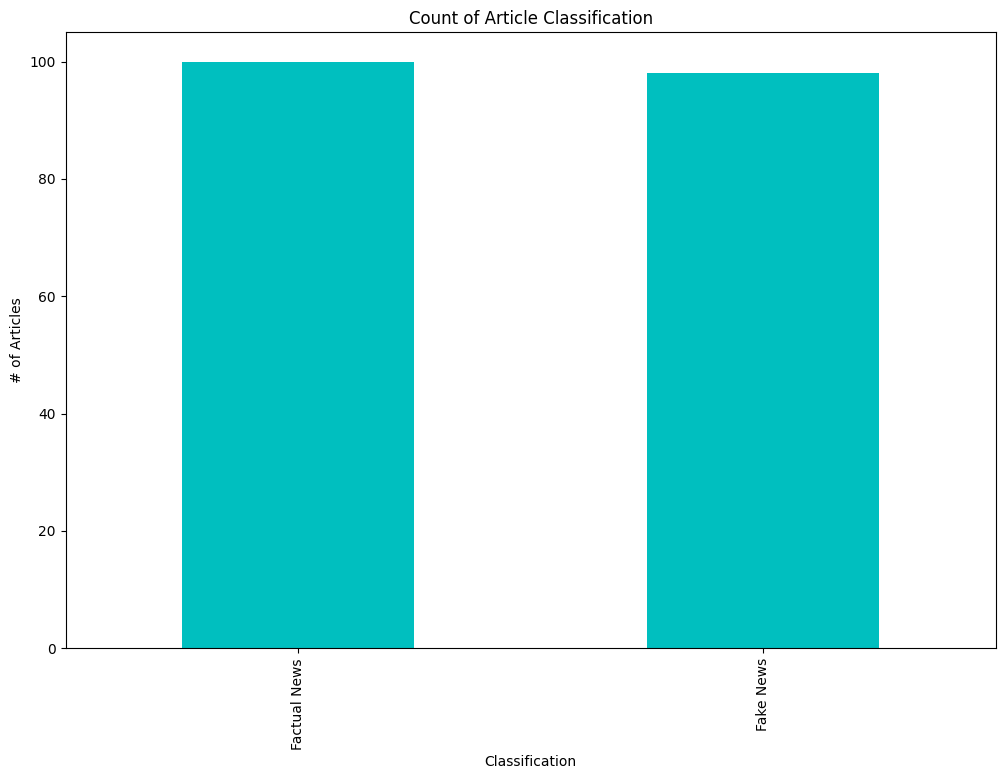

In [8]:
# plot number of fake and factual articles
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Count of Article Classification')
plt.ylabel('# of Articles')
plt.xlabel('Classification')

# Data Exploration

## POS Tagging

In [9]:
nlp = spacy.load('en_core_web_sm')

In [10]:
# split data by fake and factual news
fake_news = data[data['fake_or_factual'] == "Fake News"]
fact_news = data[data['fake_or_factual'] == "Factual News"]

In [11]:
# create spacey documents - use pipe for dataframe
fake_spaceydocs = list(nlp.pipe(fake_news['text']))
fact_spaceydocs = list(nlp.pipe(fact_news['text']))

In [12]:
# create function to extract tags for each document in our data
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [13]:
# tag fake dataset
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

for ix, doc in enumerate(fake_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

fake_tagsdf = pd.concat(fake_tagsdf)

In [14]:
# tag factual dataset
fact_tagsdf = []

for ix, doc in enumerate(fact_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

fact_tagsdf = pd.concat(fact_tagsdf)

In [15]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [16]:
# token frequency count (fake)
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795
7523,to,PART,767
4915,in,ADP,667
5094,is,AUX,419


In [17]:
# token frequency count (fact)
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672
6230,to,PART,660
4761,on,ADP,482
5586,said,VERB,452


In [18]:
# frequencies of pos tags
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

,token
pos_tag,
NOUN,2597
VERB,1814
PROPN,1657
ADJ,876
ADV,412
NUM,221
PRON,99
ADP,88
AUX,58


In [19]:
pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

,token
pos_tag,
NOUN,2182
VERB,1535
PROPN,1387
ADJ,753
ADV,271
NUM,203
PRON,81
ADP,70
AUX,44


In [20]:
# dive into diferences in nouns
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][0:15]

,token,pos_tag,counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
3134,campaign,NOUN,44
4577,government,NOUN,41
5208,law,NOUN,40
7344,t,NOUN,40
8013,years,NOUN,40


In [21]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][0:15]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4804,order,NOUN,45
4937,people,NOUN,45
2509,campaign,NOUN,42


## Named Entities

In [22]:
# top entities in fake news
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)

In [23]:
# top entities in fact news
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)

In [24]:
# create custom palette to ensure plots are consistent
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

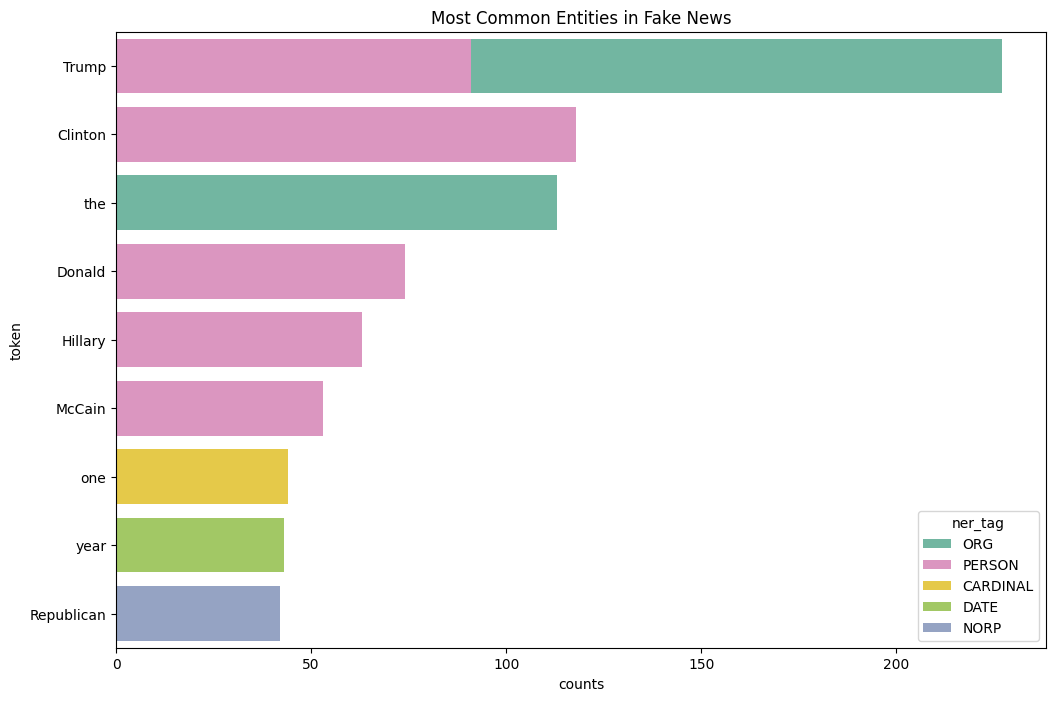

In [25]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

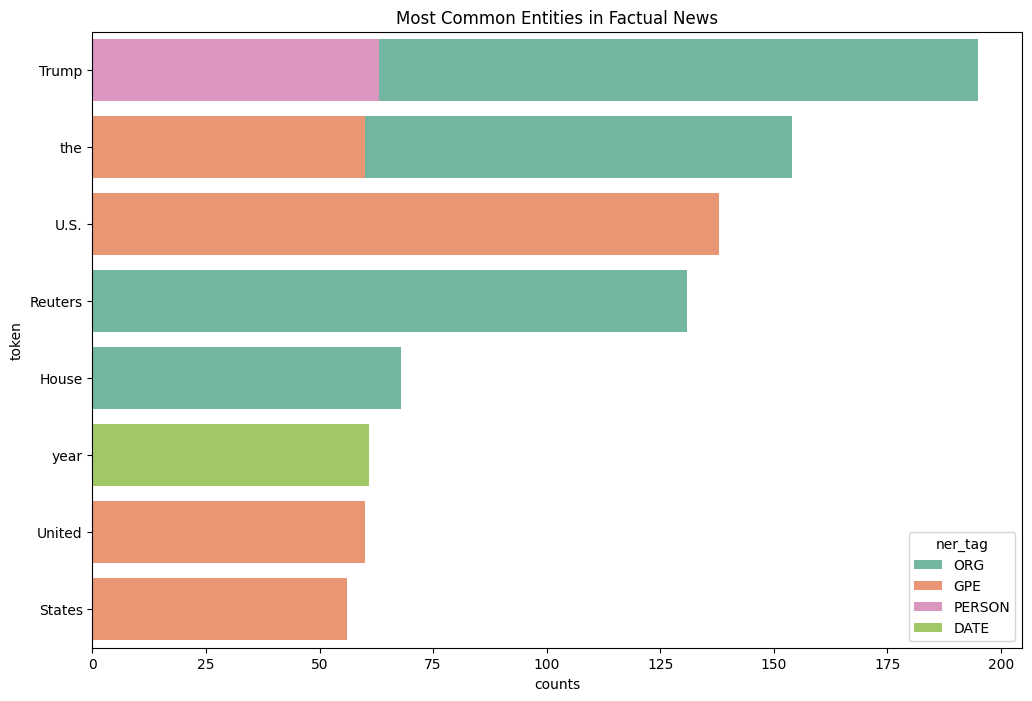

In [26]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Factual News')

# Text Pre-processing

In [27]:
# a lot of the factual news has a location tag at the beginning of the article, let's use regex to remove this
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)

In [28]:
# lowercase
data['text_clean'] = data['text_clean'].str.lower()

In [29]:
# remove punctuation
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)

In [30]:
# stop words
en_stopwords = stopwords.words('english')
print(en_stopwords) # check this against our most frequent n-grams

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [31]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [32]:
# tokenize
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [33]:
# lemmatize
lemmatizer = WordNetLemmatizer()
data["text_clean"] = data["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [34]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [35]:
# most common unigrams after preprocessing
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts())
unigrams[:10]

,count
"(said,)",560
"(trump,)",520
"(u,)",255
"(state,)",250
"(president,)",226
"(would,)",210
"(one,)",141
"(year,)",128
"(republican,)",128
"(also,)",124


<ipython-input-37-59cdbb55a1c5>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unigrams.values[:10],
<ipython-input-37-59cdbb55a1c5>:1: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=unigrams.values[:10],


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

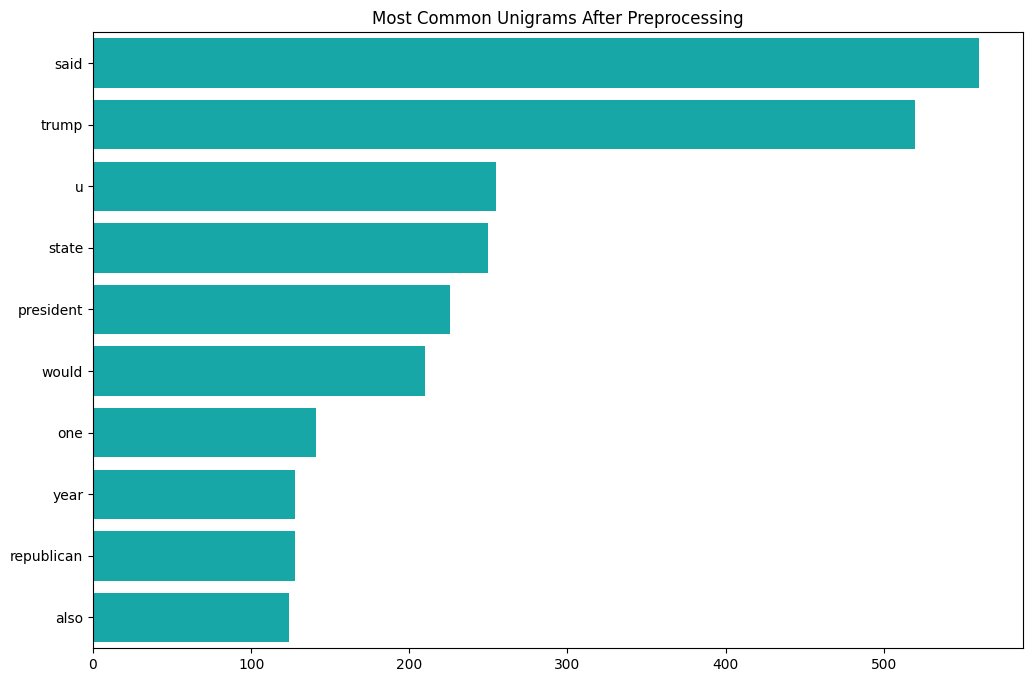

In [37]:
sns.barplot(x=unigrams.values[:10],
            y=[str(i[0]) for i in unigrams.index[:10]], # Convert the tuples to strings for y-axis labels
            orient='h',
            palette=[default_plot_colour])\
.set(title='Most Common Unigrams After Preprocessing')

In [39]:
# most common bigrams after preprocessing
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts())
bigrams[:10]

,count
"(donald, trump)",92
"(united, state)",80
"(white, house)",72
"(president, donald)",42
"(hillary, clinton)",31
"(new, york)",31
"(image, via)",29
"(supreme, court)",29
"(official, said)",26
"(food, stamp)",24


# Sentiment Analysis

## Vader

In [40]:
# use vader so we also get a neutral sentiment count
vader_sentiment = SentimentIntensityAnalyzer()

In [41]:
data['vader_sentiment_score'] = data['text'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

In [42]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

<Axes: xlabel='vader_sentiment_label'>

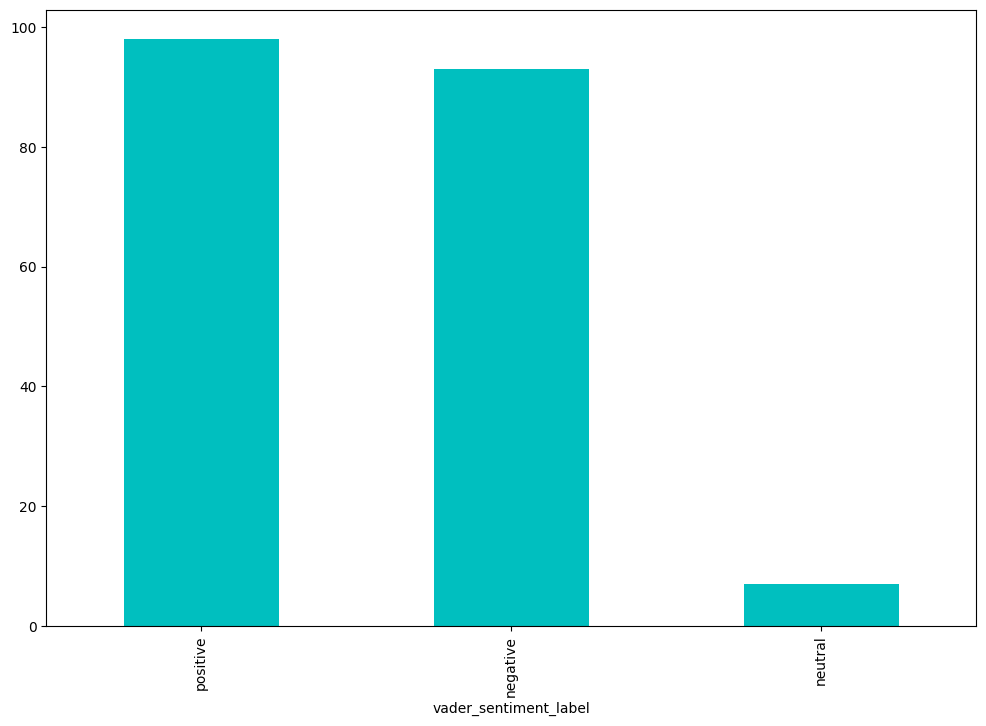

In [43]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

<ipython-input-45-f0710109be8e>:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

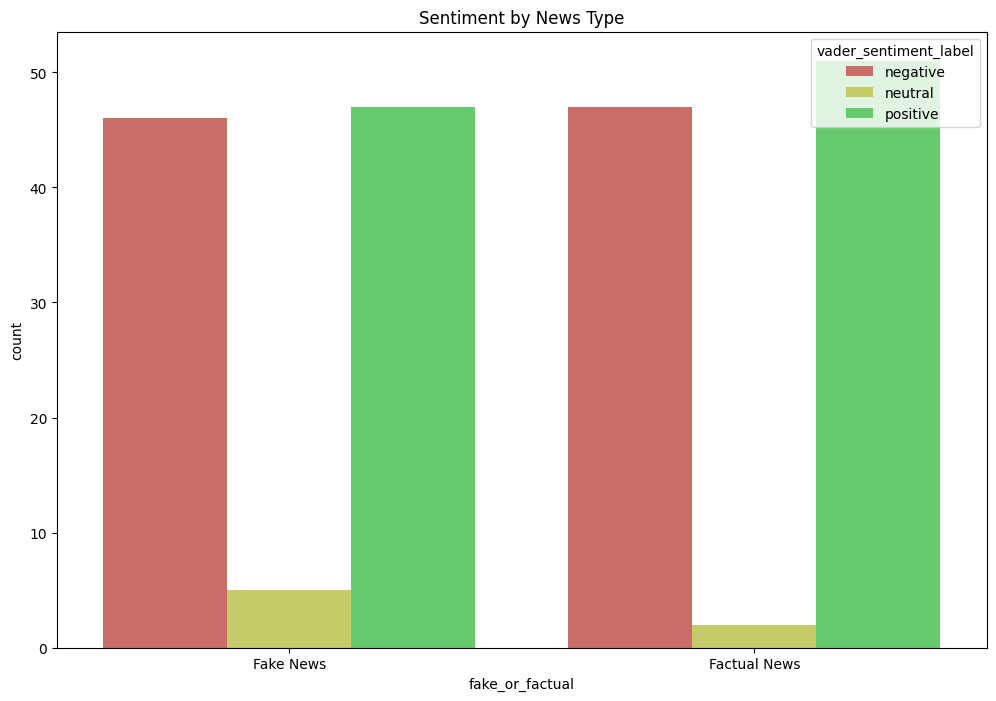

In [45]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = data
).set(title='Sentiment by News Type')

## LDA

In [46]:
# fake news data vectorization
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [47]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

In [48]:
for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

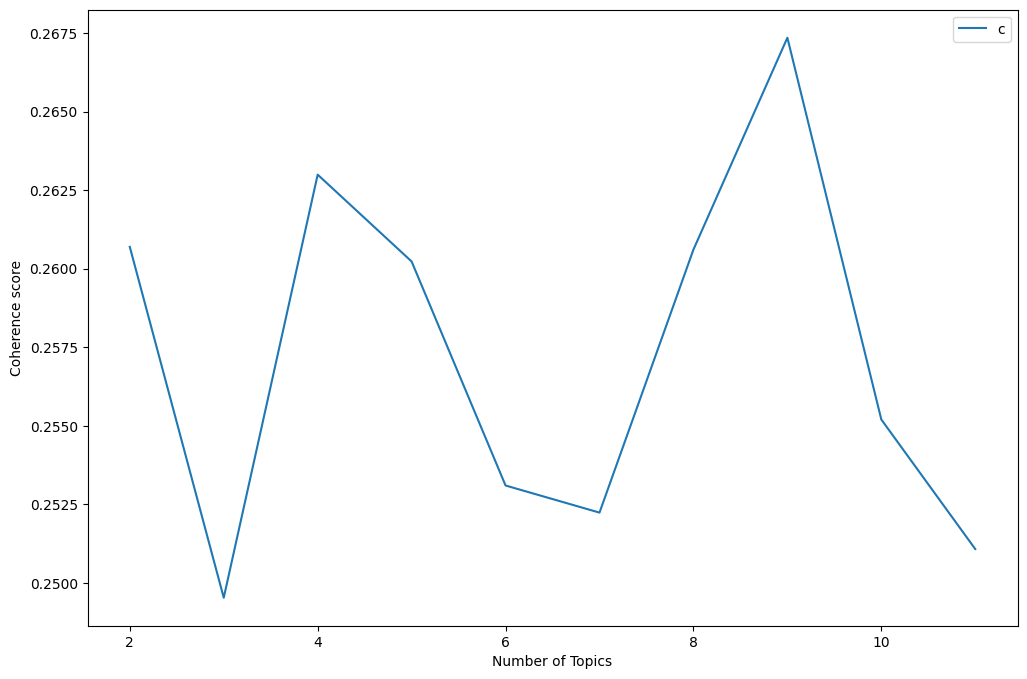

In [49]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [50]:
# create lda model
num_topics_fake = 9

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.005*"said" + 0.005*"trump" + 0.004*"u" + 0.004*"time" + 0.004*"state" + 0.004*"would" + 0.003*"go" + 0.003*"woman" + 0.003*"know" + 0.003*"one"'),
 (1,
  '0.011*"trump" + 0.005*"clinton" + 0.005*"said" + 0.004*"state" + 0.004*"one" + 0.004*"would" + 0.003*"republican" + 0.003*"mccain" + 0.003*"u" + 0.003*"image"'),
 (2,
  '0.007*"clinton" + 0.006*"trump" + 0.004*"u" + 0.003*"said" + 0.003*"one" + 0.003*"republican" + 0.003*"woman" + 0.003*"american" + 0.002*"president" + 0.002*"state"'),
 (3,
  '0.006*"trump" + 0.006*"u" + 0.006*"president" + 0.005*"would" + 0.004*"one" + 0.004*"said" + 0.004*"syria" + 0.003*"mccain" + 0.003*"year" + 0.003*"republican"'),
 (4,
  '0.005*"clinton" + 0.004*"woman" + 0.004*"trump" + 0.004*"would" + 0.004*"year" + 0.004*"state" + 0.003*"million" + 0.003*"said" + 0.003*"food" + 0.003*"u"'),
 (5,
  '0.021*"trump" + 0.005*"people" + 0.004*"time" + 0.004*"president" + 0.004*"vote" + 0.004*"donald" + 0.004*"state" + 0.004*"would" + 0.004*"like" + 0.003

## TF-IDF & LSA

In [51]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [52]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

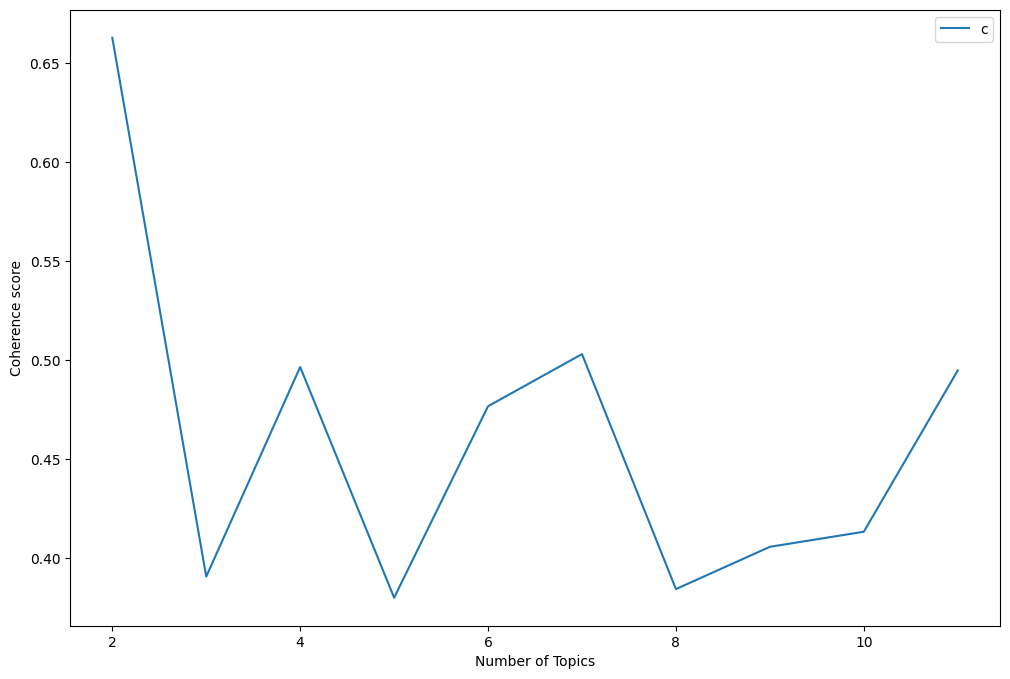

In [53]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [54]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=2)
lsa_fake.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '-0.299*"boiler" + -0.253*"room" + -0.250*"acr" + -0.186*"jay" + -0.185*"animal" + -0.176*"episode" + -0.147*"analysis" + -0.122*"dyer" + -0.119*"corner" + -0.119*"savant"')]

## Predict fake or factual news

In [55]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [56]:
X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [57]:
# text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [58]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

### Logistic Regression

In [63]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [64]:
y_pred_lr = lr.predict(X_test)

In [65]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.91      0.91      0.91        33
   Fake News       0.89      0.89      0.89        27

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



### SVM

In [59]:
svm = SGDClassifier().fit(X_train, y_train)

In [60]:
y_pred_svm = svm.predict(X_test)

In [62]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.91      0.94      0.93        33
   Fake News       0.92      0.89      0.91        27

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.92        60
weighted avg       0.92      0.92      0.92        60

